**DATA CLEANING**

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Define the path to your Excel file
excel_path = r'/content/Nashik_Module_4_Data.csv'

# Read the Excel file into a DataFrame
df = pd.read_csv(excel_path)

In [ ]:
# Ensure the 'Date' column is of datetime type
df['Dates'] = pd.to_datetime(df['Dates'])

# Sort the DataFrame by the 'Date' column
df.sort_values(by='Dates', inplace=True)

# Generate a list of consecutive dates
start_date = df['Dates'].min()
end_date = df['Dates'].max()

<ipython-input-12-7f34552333b0>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


In [ ]:
date_range = pd.date_range(start_date, end_date, freq='D')

In [ ]:
# Find missing dates
missing_dates = date_range[~date_range.isin(df['Dates'])]

# Create a DataFrame for missing dates with NaN values for 'Price'
missing_df = pd.DataFrame({'Dates': missing_dates, 'Price': np.nan,'Arrival':np.nan})

In [ ]:
# Fill missing 'Price' values with the mean of the existing 'Price' values
df['Price'].fillna(df['Price'].mean(), inplace=True)

<ipython-input-15-6be6555411c0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(df['Price'].mean(), inplace=True)


In [ ]:
# Ensure the 'Arrival' column is numeric
df['Arrival'] = pd.to_numeric(df['Arrival'], errors='coerce')

# Fill missing values with the column mean
df['Arrival'].fillna(df['Arrival'].mean(), inplace=True)


<ipython-input-16-b3f566c001fe>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Arrival'].fillna(df['Arrival'].mean(), inplace=True)


In [ ]:
# Save the updated DataFrame to a new Excel file
output_excel_path = r'/content/Nashik_Onion_Updated_file_final12-24.csv'
df.to_csv(output_excel_path, index=False)

In [ ]:
print(f"Missing dates found: {len(missing_dates)}")

Missing dates found: 2003


**ARIMA**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
#plt.style.use('fivethirtyeight')

In [ ]:
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import math
from sklearn.metrics import mean_squared_error
from random import random
import datetime

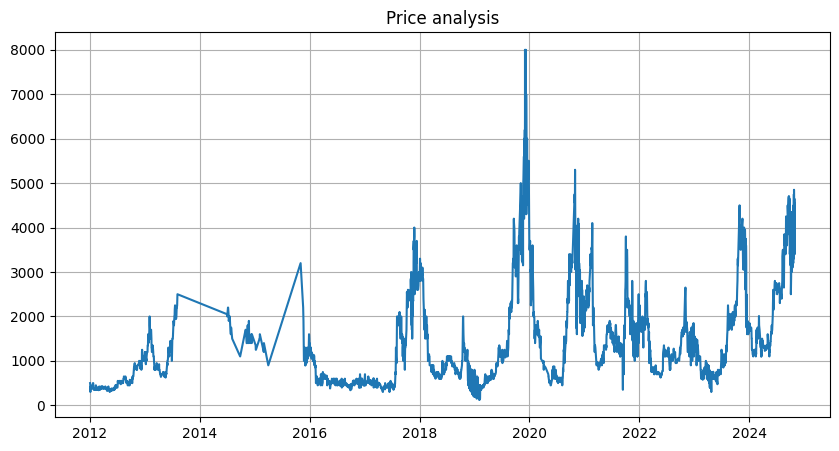

In [ ]:
df=pd.read_csv("/content/Nashik_Onion_Updated_file_final12-24.csv")
import pandas as pd
df['Dates']=pd.to_datetime(df['Dates'],infer_datetime_format=True)
df.head(1)
df.set_index('Dates', inplace=True)
df.head(1)
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(df['Price'])
plt.title('Price analysis')
plt.grid(True)
plt.show();

In [ ]:
df.describe()

,Price,Arrival
count,2903.000000,2903.00000
mean,1425.704788,214.93632
std,1071.644356,120.90547
min,125.000000,1.00000
25%,617.500000,134.00000
50%,1100.000000,203.00000
75%,1800.000000,281.00000
max,8000.000000,880.50000


In [ ]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Price'])
test_result

### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller
test_result1=adfuller(df['Price'].diff().dropna())
test_result1


(-10.15799398333685,
 7.639156396952769e-18,
 28,
 2873,
 {'1%': -3.4326281595184787,
  '5%': -2.862546536224071,
  '10%': -2.567305808466284},
 40112.90383361799)

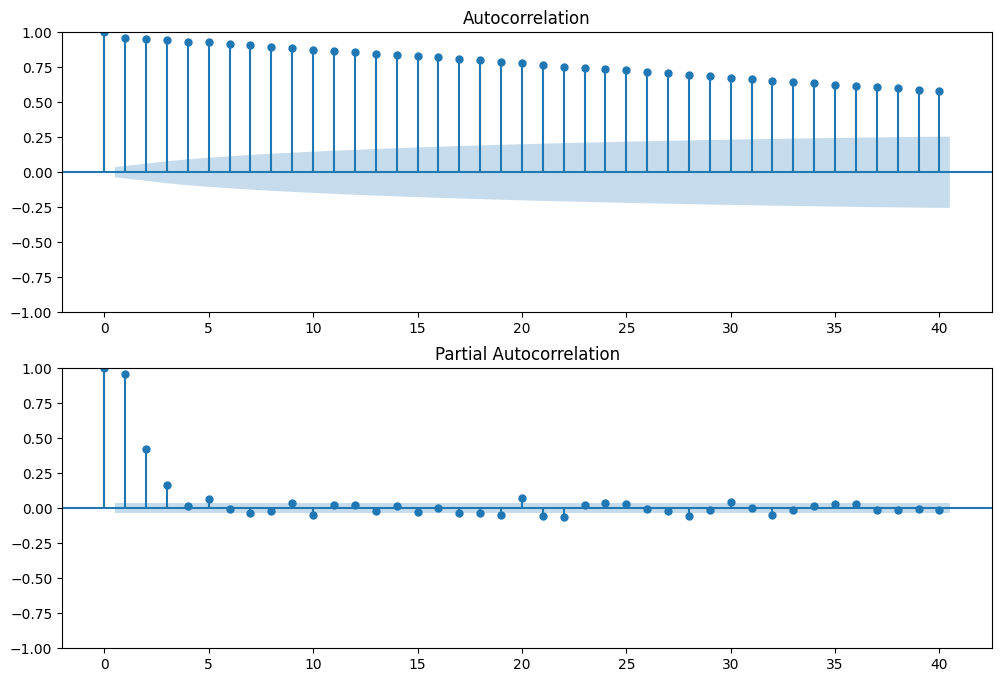

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df['Price'], lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df['Price'], lags=40, ax=ax2)
plt.show()

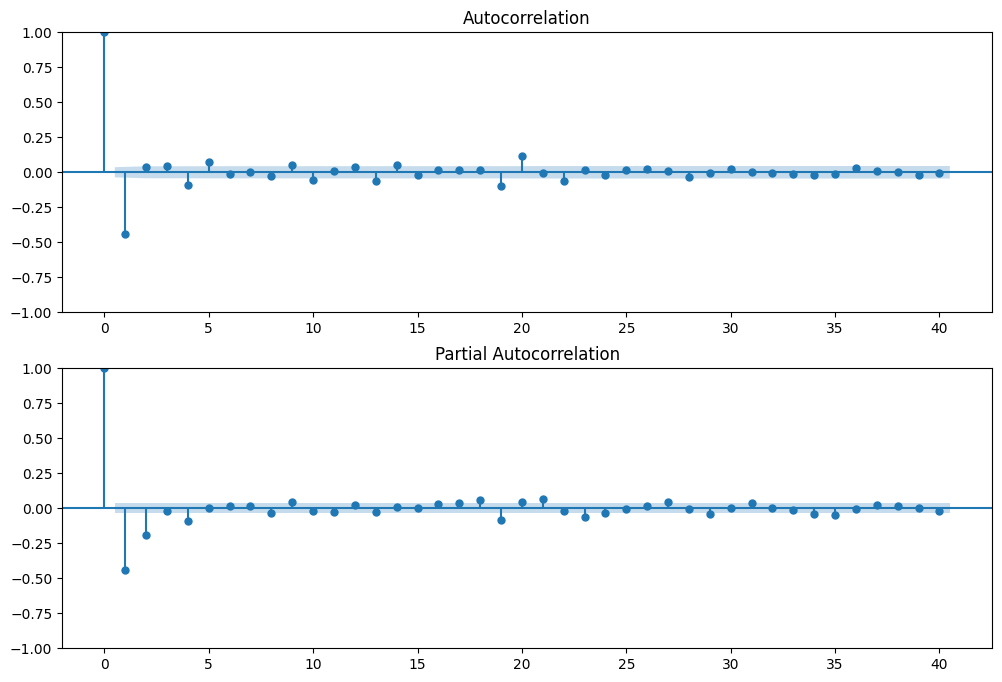

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
#Plots with first order differenced Sales variable
fig=sm.graphics.tsa.plot_acf(df['Price'].diff().dropna(), lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df['Price'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [ ]:
X=df['Price']
X=X.values
train, test=X[0:len(X)-60], X[len(X)-60:]

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=40309.749, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40984.297, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40438.492, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40321.351, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40982.332, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40319.816, Time=3.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40317.512, Time=2.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=40308.704, Time=2.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=40315.117, Time=6.02 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=40297.357, Time=7.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=40302.755, Time=1.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=40287.098, Time=12.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=40304.969, Time=1.19 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=40297.041, Time=24.96 sec
 ARIMA(4,1,3)(0,0

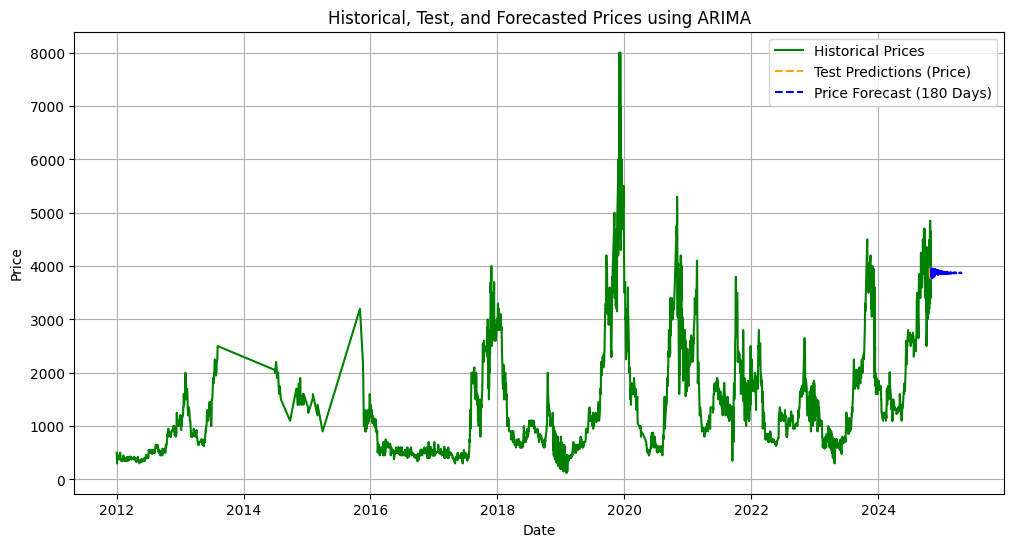

RMSE: 627.3760584228435
NRMSE (%): 40.48


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('/content/Nashik_Onion_Updated_file_final12-24 (1).csv', parse_dates=['Dates'], index_col='Dates')

# Select the 'Price' column for forecasting
data = data[['Price']]

# Check for missing values and drop them
data = data.dropna()

# Train-test split (last 12 points for testing)
train_df = data[:-12]
test_df = data[-12:]

# Fit AutoARIMA model to the training data
model = auto_arima(train_df, seasonal=False, stepwise=True, trace=True)

# Print the summary of the fitted model
print(model.summary())

# Forecast for the test set (next 12 days)
test_predictions = model.predict(n_periods=12)

# Forecast for the next 180 days
forecast_steps = 180
forecast = model.predict(n_periods=forecast_steps)

# Create a date range for the forecasted period (next 180 days)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'Price': np.concatenate([data['Price'].values, forecast])
}, index=data.index.append(forecast_index))

# Plot the results (train, test, and forecast for 180 days)
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data.index, data['Price'], label='Historical Prices', color='green')

# Plot test predictions
plt.plot(test_df.index, test_predictions, label='Test Predictions (Price)', color='orange', linestyle='--')

# Plot forecast for the next 180 days
plt.plot(forecast_index, forecast, label='Price Forecast (180 Days)', color='blue', linestyle='--')

plt.title('Historical, Test, and Forecasted Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE and NRMSE for test predictions
rmse = np.sqrt(mean_squared_error(test_df['Price'], test_predictions))
nrmse = (rmse / (test_df['Price'].max() - test_df['Price'].min())) * 100

print(f"RMSE: {rmse}")
print(f"NRMSE (%): {nrmse:.2f}")

In [ ]:
forecast_df

,Price
2012-01-02,500.000000
2012-01-03,475.000000
2012-01-04,300.000000
2012-01-05,400.000000
2012-01-06,400.000000
...,...
2025-04-24,3870.361320
2025-04-25,3873.677645
2025-04-26,3870.734713
2025-04-27,3870.521744


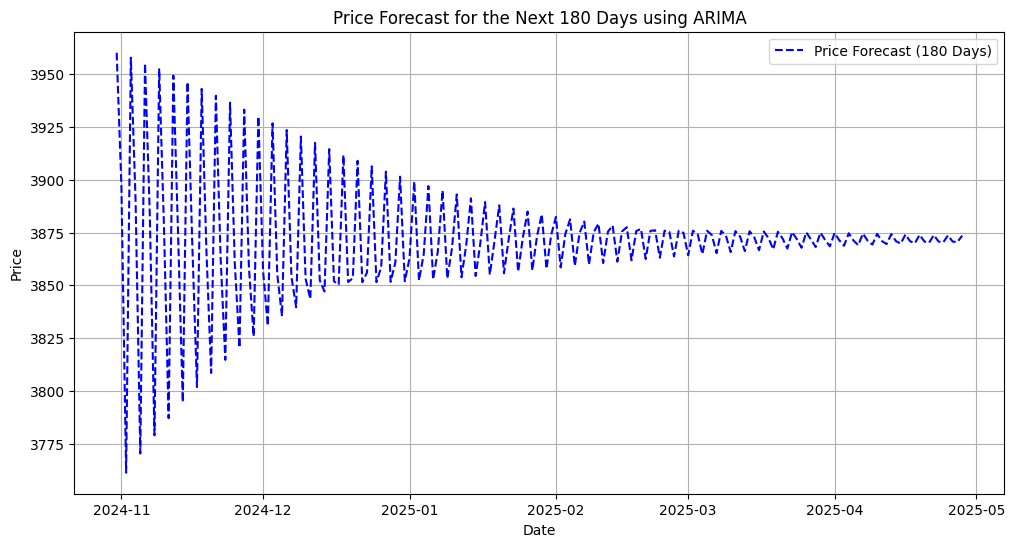

In [ ]:
# Plot the Price Forecast for the next 180 Days
plt.figure(figsize=(12, 6))

# Plot forecast for the next 180 days
plt.plot(forecast_index, forecast, label='Price Forecast (180 Days)', color='blue', linestyle='--')

plt.title('Price Forecast for the Next 180 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.6 MB/s eta 0:00:00


**SARIMA**

In [ ]:
forecast_results.to_csv("sarima_forecast_results_no_exog.csv", index=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=40311.465, Time=6.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=40984.297, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=40437.207, Time=1.78 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=40320.991, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=40982.332, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=40309.447, Time=4.26 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=40309.749, Time=1.56 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=40311.424, Time=12.90 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=40309.457, Time=4.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=40313.442, Time=15.79 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=40320.003, Time=7.50 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=40317.566, Time=3.01 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=40308.411, Time=6.18 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=40308.704, Time=5.07 sec
 AR

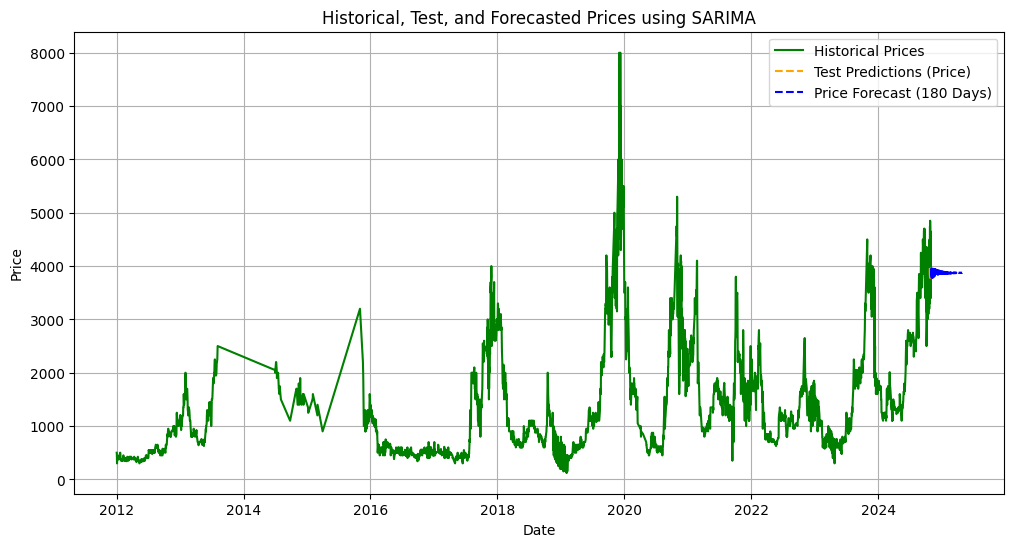

RMSE: 627.3760584228435
NRMSE (%): 40.48


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('/content/Nashik_Onion_Updated_file_final12-24 (1).csv', parse_dates=['Dates'], index_col='Dates')

# Select the 'Price' column for forecasting
data = data[['Price']]

# Check for missing values and drop them
data = data.dropna()

# Train-test split (last 12 points for testing)
train_df = data[:-12]
test_df = data[-12:]

# Fit SARIMA model to the training data
# Seasonal period is set to 365 for daily data with yearly seasonality (adjust if necessary)
model = auto_arima(train_df, seasonal=True, m=12, stepwise=True, trace=True)

# Print the summary of the fitted model
print(model.summary())

# Forecast for the test set (next 12 days)
test_predictions = model.predict(n_periods=12)

# Forecast for the next 180 days
forecast_steps = 180
forecast = model.predict(n_periods=forecast_steps)

# Create a date range for the forecasted period (next 180 days)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'Price': np.concatenate([data['Price'].values, forecast])
}, index=data.index.append(forecast_index))

# Plot the results (train, test, and forecast for 180 days)
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data.index, data['Price'], label='Historical Prices', color='green')

# Plot test predictions
plt.plot(test_df.index, test_predictions, label='Test Predictions (Price)', color='orange', linestyle='--')

# Plot forecast for the next 180 days
plt.plot(forecast_index, forecast, label='Price Forecast (180 Days)', color='blue', linestyle='--')

plt.title('Historical, Test, and Forecasted Prices using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE and NRMSE for test predictions
rmse = np.sqrt(mean_squared_error(test_df['Price'], test_predictions))
nrmse = (rmse / (test_df['Price'].max() - test_df['Price'].min())) * 100

print(f"RMSE: {rmse}")
print(f"NRMSE (%): {nrmse:.2f}")


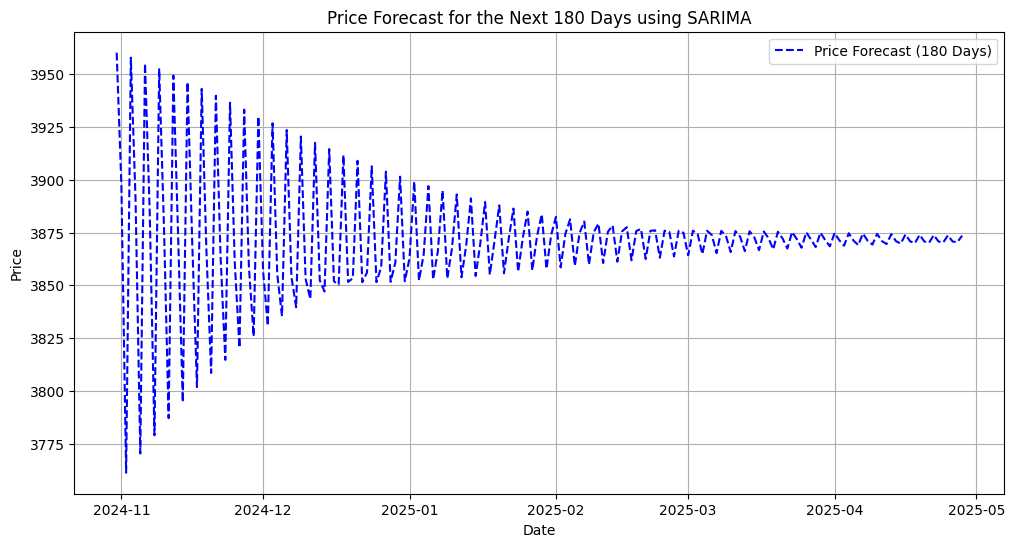

In [ ]:
# Plot the Price Forecast for the next 180 Days
plt.figure(figsize=(12, 6))

# Plot forecast for the next 180 days
plt.plot(forecast_index, forecast, label='Price Forecast (180 Days)', color='blue', linestyle='--')

plt.title('Price Forecast for the Next 180 Days using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


SARIMA **EXOGENOUS**

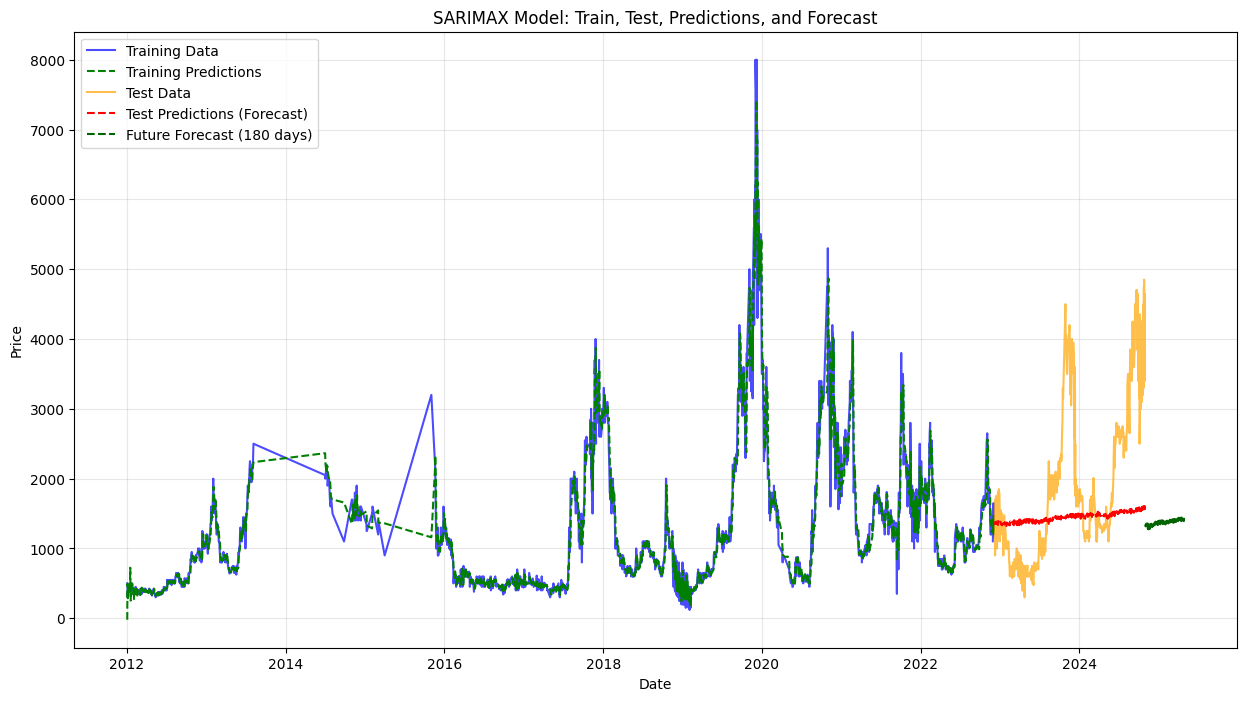

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
df = pd.read_csv("/content/Nashik_Onion_Updated_file_final12-24 (1).csv")  # Replace with your CSV file path
df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
df.set_index('Dates', inplace=True)

# Check for missing values in both 'Price' and 'Arrival'
df = df[['Price', 'Arrival']].dropna()

# Split data into train and test
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Define endogenous (Price) and exogenous (Arrival) variables
endog_train = train['Price']
endog_test = test['Price']
exog_train = train[['Arrival']]
exog_test = test[['Arrival']]

# Step 2: Fit SARIMAX Model
sarimax_model = SARIMAX(endog_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_fitted = sarimax_model.fit(disp=False)

# Step 3: Forecast on Test Data and beyond
n_forecast = len(test)
forecasted_values = sarimax_fitted.get_forecast(steps=n_forecast, exog=exog_test).predicted_mean

# Forecast beyond the test set (e.g., next 180 days)
forecast_horizon = 180
future_exog = exog_test[-forecast_horizon:]  # You need to define future arrival data for these 180 days
forecast_future = sarimax_fitted.get_forecast(steps=forecast_horizon, exog=future_exog).predicted_mean

# Step 4: Generate Train Predictions
train_predictions = sarimax_fitted.predict(start=0, end=len(endog_train) - 1, exog=exog_train)

# Step 5: Plot Train, Test, Predictions, and Forecast
plt.figure(figsize=(15, 8))

# Plot the training data
plt.plot(train.index, train['Price'], label="Training Data", color="blue", alpha=0.7)

# Plot the training predictions
plt.plot(train.index, train_predictions, label="Training Predictions", color="green", linestyle="--")

# Plot the test data
plt.plot(test.index, test['Price'], label="Test Data", color="orange", alpha=0.7)

# Plot the test predictions (forecasted values)
plt.plot(test.index, forecasted_values, label="Test Predictions (Forecast)", color="red", linestyle="--")

# Plot the future forecast (next 180 days)
forecast_index = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
plt.plot(forecast_index, forecast_future, label="Future Forecast (180 days)", color="darkgreen", linestyle="--")

# Add titles and labels
plt.title("SARIMAX Model: Train, Test, Predictions, and Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


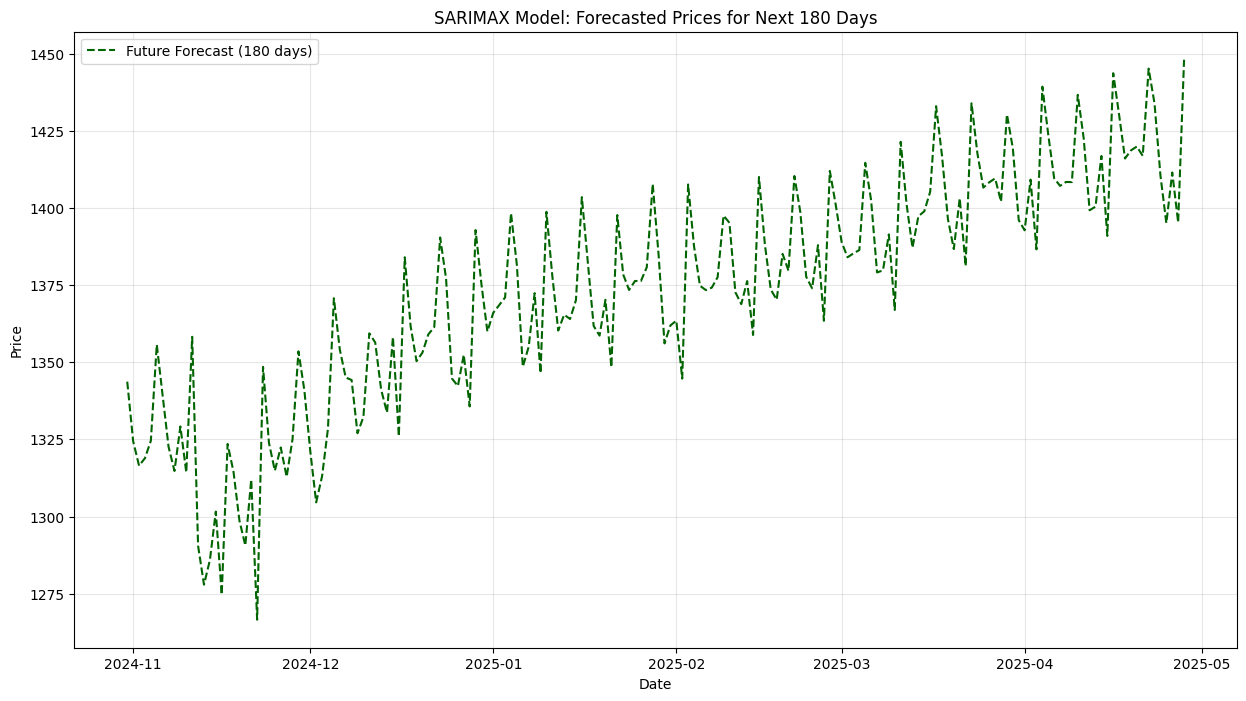

In [ ]:
# Plotting the Future Forecast (180 days)
plt.figure(figsize=(15, 8))

# Generate future forecast index
forecast_index = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Plot the future forecast (next 180 days)
plt.plot(forecast_index, forecast_future, label="Future Forecast (180 days)", color="darkgreen", linestyle="--")

# Add titles and labels
plt.title("SARIMAX Model: Forecasted Prices for Next 180 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for Test Predictions
rmse = np.sqrt(mean_squared_error(endog_test, forecasted_values))

# Calculate NRMSE as a percentage (normalized by the range of actual values in test data)
nrmse = rmse / (endog_test.max() - endog_test.min()) * 100

# Print RMSE and NRMSE percentage
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}%")


RMSE: 1233.9883374597837
NRMSE: 27.120622801313925%


**ARCH**

In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.0 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32197.091, Time=4.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32495.241, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32321.225, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32226.553, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32493.245, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32195.629, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32200.716, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32208.055, Time=0.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32196.734, Time=1.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32194.738, Time=0.45 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=32196.755, Time=0.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=32198.740, Time=0.68 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=32192.744, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32198.718, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0

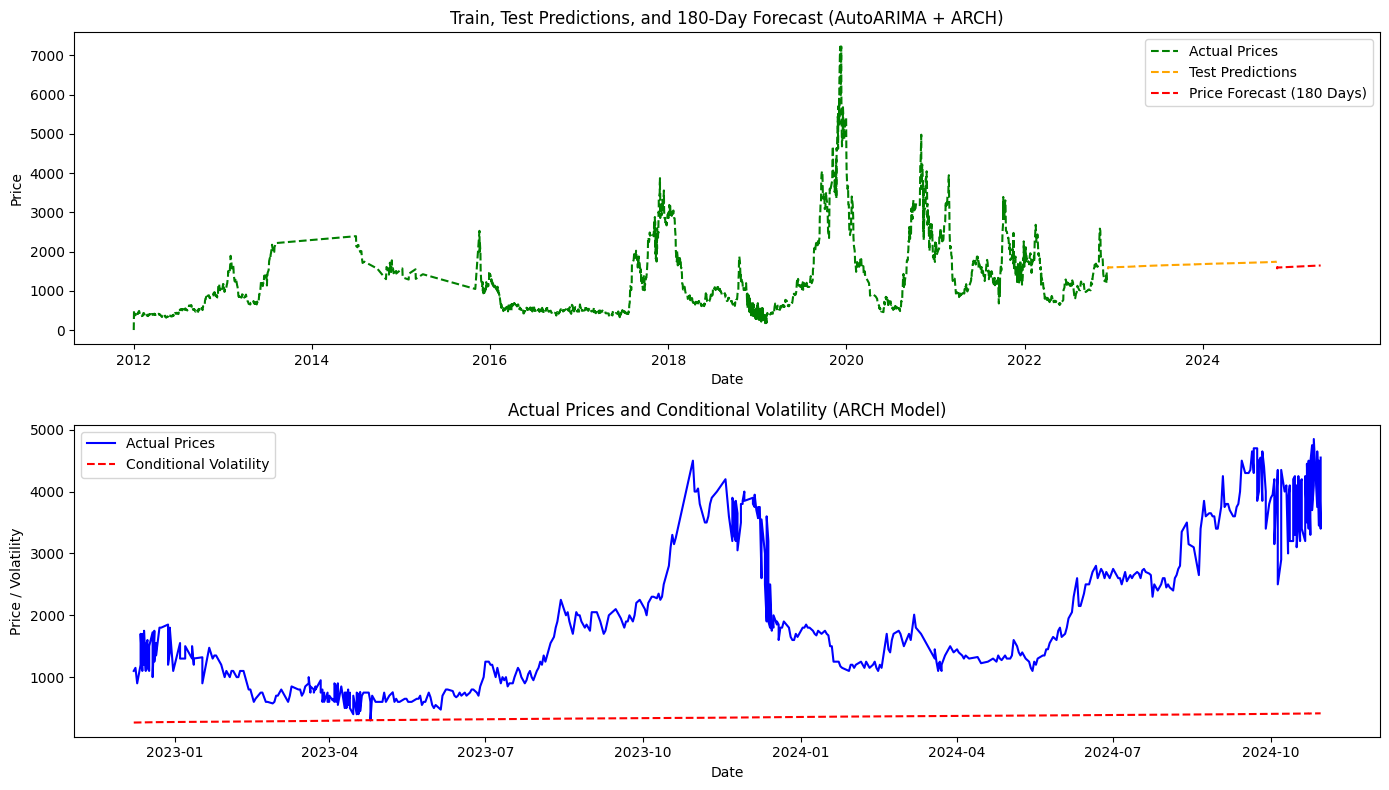

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Load your data
csv_file = "/content/Nashik_Onion_Updated_file_final12-24 (1).csv"  # Replace with your CSV file path
df = pd.read_csv(csv_file)

# Assuming 'Price' is your target variable and 'Arrival' is exogenous variable
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.sort_values('Dates').set_index('Dates')

# Define the target column
price_col = 'Price'  # Replace with your actual column name
arrival_col = 'Arrival'  # Replace with your actual column name

# Step 2: Fit AutoARIMA Model
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Fit AutoARIMA on the training data
auto_arima_model = auto_arima(train_df[price_col], seasonal=False, m=12, stepwise=True, trace=True)

# Step 3: Extract residuals from the AutoARIMA model
residuals = auto_arima_model.resid()

# Step 4: Fit the ARCH model to the residuals
arch_model_fit = arch_model(residuals, vol='Garch', p=1, q=1)
arch_fitted = arch_model_fit.fit(disp="off")

# Step 5: Forecast the residuals using the ARCH model
forecast_length = len(test_df)  # Forecasting the same length as the test set
arch_forecast = arch_fitted.forecast(horizon=forecast_length)

# Step 6: Forecast the 'Price' using AutoARIMA and add the forecasted residuals
arima_forecast = auto_arima_model.predict(n_periods=forecast_length)

# Forecast the final 'Price' by adding the forecasted residuals
forecasted_residuals = arch_forecast.variance.values[-1, :]
final_forecast = arima_forecast + np.sqrt(forecasted_residuals)  # Adjusting with the forecasted volatility

# Step 7: Forecast for the next 180 days (Extend the forecast)
forecast_steps = 180
arima_forecast_180 = auto_arima_model.predict(n_periods=forecast_steps)

# Forecast the residuals for the next 180 days using the ARCH model
arch_forecast_180 = arch_fitted.forecast(horizon=forecast_steps)
forecasted_residuals_180 = arch_forecast_180.variance.values[-1, :]

# Combine ARIMA forecast with forecasted residuals for the next 180 days
final_forecast_180 = arima_forecast_180 + np.sqrt(forecasted_residuals_180)

# Create forecast index for the next 180 days
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Step 8: Evaluate the forecast performance on the test data
rmse = np.sqrt(mean_squared_error(test_df[price_col], final_forecast))
nrmse = (rmse / (test_df[price_col].max() - test_df[price_col].min())) * 100
print("RMSE on Test Data:", rmse)
print(f"NRMSE (%): {nrmse:.2f}")

# Step 9: Visualization
plt.figure(figsize=(14, 8))

# Plot train predictions, test predictions, and 180-day forecast on the same graph
plt.subplot(2, 1, 1)
plt.plot(train_df.index, auto_arima_model.predict_in_sample(), label="Actual Prices", color="green", linestyle="--")
plt.plot(test_df.index, final_forecast, label="Test Predictions", color="orange", linestyle="--")
plt.plot(forecast_index, final_forecast_180, label="Price Forecast (180 Days)", color="red", linestyle="--")
plt.legend()
plt.title("Train, Test Predictions, and 180-Day Forecast (AutoARIMA + ARCH)")
plt.xlabel("Date")
plt.ylabel("Price")

# Plot the actual prices with conditional volatility
plt.subplot(2, 1, 2)
plt.plot(test_df.index, test_df[price_col], label="Actual Prices", color="blue")
plt.plot(test_df.index, np.sqrt(forecasted_residuals), label="Conditional Volatility", color="red", linestyle="--")
plt.legend()
plt.title("Actual Prices and Conditional Volatility (ARCH Model)")
plt.xlabel("Date")
plt.ylabel("Price / Volatility")

plt.tight_layout()
plt.show()


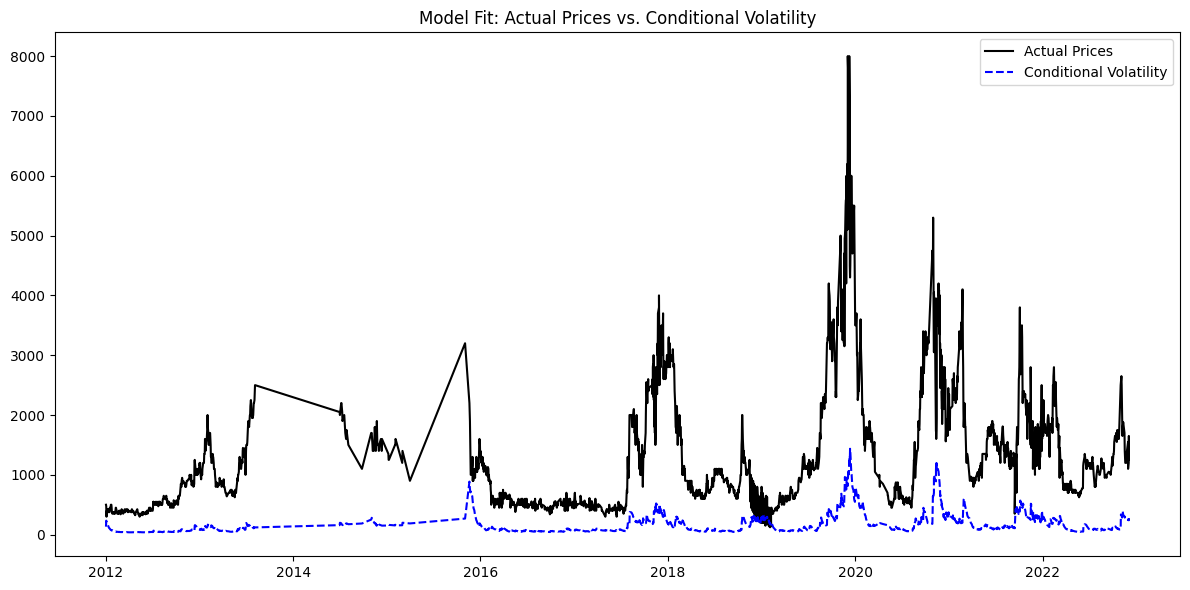

In [ ]:
import matplotlib.pyplot as plt
from arch import arch_model

# Fit the ARCH model (assuming you have the residuals 'residuals' from the ARIMA model)
arch_model_fit = arch_model(residuals, vol='Garch', p=1, q=1)
arch_fitted = arch_model_fit.fit(disp="off")

# Extract conditional volatility from the fitted ARCH model
conditional_volatility = arch_fitted.conditional_volatility

# Plot the conditional volatility along with actual prices
fig = plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(train_df['Price'], label='Actual Prices', linestyle='-', color='black')

# Plot conditional volatility
plt.plot(conditional_volatility, label='Conditional Volatility', linestyle='--', color='blue')

# Add title and legend
plt.title('Model Fit: Actual Prices vs. Conditional Volatility')
plt.legend()

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('Actual Prices vs Conditional Volatility for ARCH.png')

# Show the plot
plt.show()


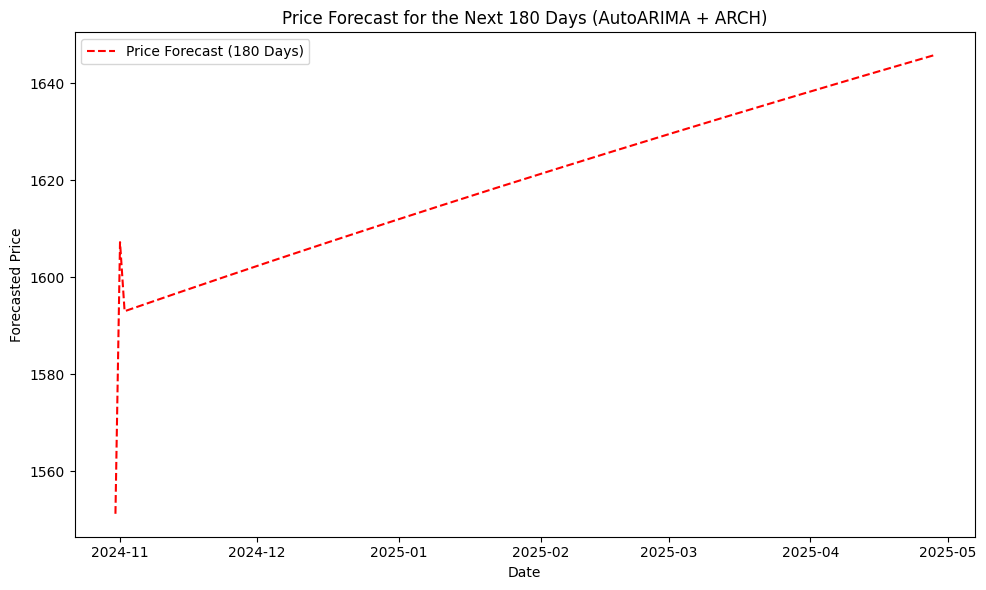

In [ ]:
# Plotting the forecasted prices with dates only (for the next 180 days)
plt.figure(figsize=(10, 6))
plt.plot(forecast_index, final_forecast_180, label="Price Forecast (180 Days)", color="red", linestyle="--")

# Add labels and title
plt.title("Price Forecast for the Next 180 Days (AutoARIMA + ARCH)")
plt.xlabel("Date")
plt.ylabel("Forecasted Price")

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


**VAR MODEL**

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#Load the dataset
data = pd.read_csv('/content/Nashik_Onion_Updated_file_final12-24.csv', parse_dates=['Dates'], index_col='Dates')

# Select relevant columns
data = data[['Price', 'Arrival']]
print(f"Dataset shape: {data.shape}")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())
# Drop missing values
data = data.dropna()
# Augmented Dickey-Fuller Test (ADF) for stationarity
def check_stationarity(series, name):
    adf_result = adfuller(series.dropna())
    print(f"{name}:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("\n")

# Test stationarity for Price and Arrival
print("Testing stationarity for each variable:")
check_stationarity(data['Price'], "Price")
check_stationarity(data['Arrival'], "Arrival")

# Use only stationary series for modeling
data_stationary = data[['Arrival', 'Price']].dropna()


# Train-test split
train_df = data_stationary[:-12]
test_df = data_stationary[-12:]
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

model = VAR(train_df.diff()[1:])

sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())



Dataset shape: (2903, 2)
            Price  Arrival
Dates                     
2012-01-02    500    194.0
2012-01-03    475    174.0
2012-01-04    300      7.0
2012-01-05    400    264.0
2012-01-06    400    192.5

Missing values:
Price      0
Arrival    0
dtype: int64
Testing stationarity for each variable:
Price:
ADF Statistic: -3.6760767600588684
p-value: 0.00446252038495993


Arrival:
ADF Statistic: -7.004269359423282
p-value: 7.189258477586853e-10


Train shape: (2891, 2)
Test shape: (12, 2)
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.98       19.99   4.770e+08       19.98
1        19.72       19.73   3.659e+08       19.72
2        19.64       19.66   3.374e+08       19.64
3        19.62       19.65   3.317e+08       19.63
4        19.60      19.64*   3.256e+08       19.61
5        19.60       19.64   3.240e+08       19.61
6        19.59       19.65   3.233e+08 

            Arrival  Price
Dates                     
2012-01-02    194.0    500
2012-01-03    174.0    475
2012-01-04      7.0    300
2012-01-05    264.0    400
2012-01-06    192.5    400


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


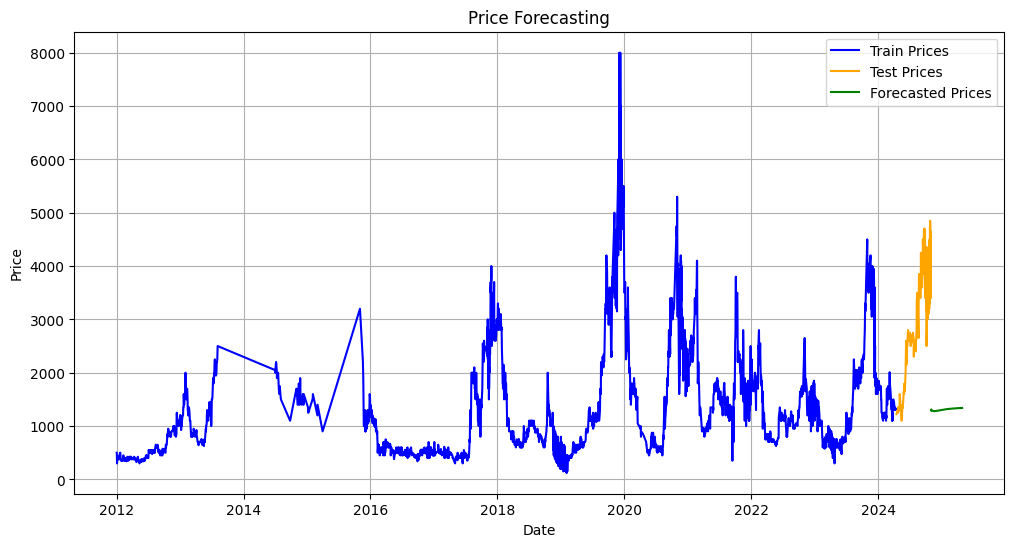

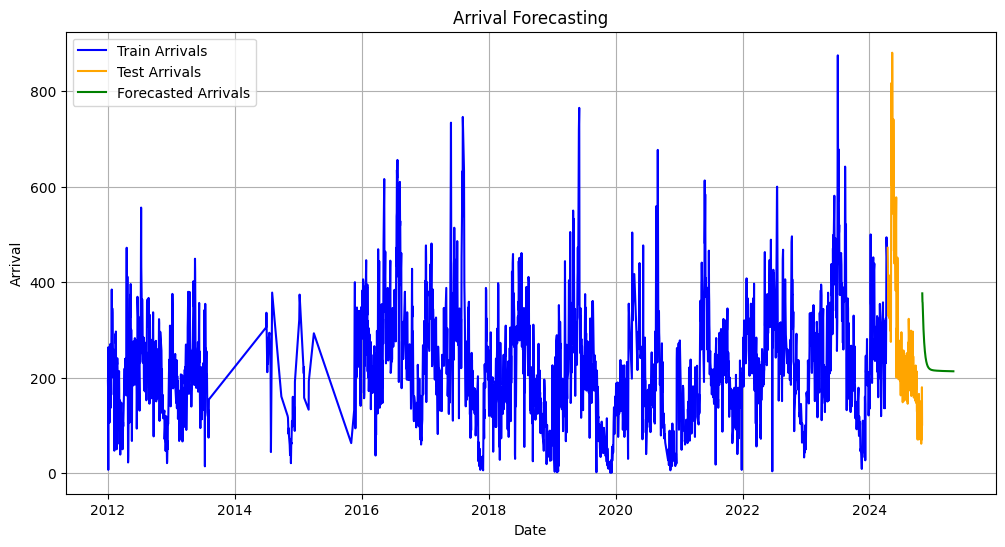

Price RMSE: 1949.1751834626377
Price NRMSE: 51.98%
Arrival RMSE: 146.6751554713584
Arrival NRMSE: 17.91%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Define the path to your CSV file
csv_file_path = '/content/Nashik_Onion_Updated_file_final12-24 (1).csv'  # Update this with your actual file path

# Load the data from the CSV file
data = pd.read_csv(csv_file_path, parse_dates=['Dates'], index_col='Dates')  # Assuming the column 'Dates' exists in your CSV

# Check the structure of your data
print(data.head())

# Split data into train and test sets
train_df = data.iloc[:-180]  # Use all but the last 180 data points for training
test_df = data.iloc[-180:]   # Use the last 180 data points for testing

# Fit VAR model with lag 4
model = VAR(train_df)
fitted_model = model.fit(4)  # Use lag_order=4

# Forecast for the next 180 days (steps)
forecast_steps = 180
forecast = fitted_model.forecast(train_df.values[-4:], steps=forecast_steps)

# Create a date range for the forecasted period (next 180 days)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for results
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=train_df.columns)

# Calculate RMSE and NRMSE for Price
rmse_price = np.sqrt(mean_squared_error(test_df['Price'], forecast_df['Price']))
nrmse_price = (rmse_price / (test_df['Price'].max() - test_df['Price'].min())) * 100

# Calculate RMSE and NRMSE for Arrival
rmse_arrival = np.sqrt(mean_squared_error(test_df['Arrival'], forecast_df['Arrival']))
nrmse_arrival = (rmse_arrival / (test_df['Arrival'].max() - test_df['Arrival'].min())) * 100

# Plot Price
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Price'], label='Train Prices', color='blue')
plt.plot(test_df.index, test_df['Price'], label='Test Prices', color='orange')
plt.plot(forecast_df.index, forecast_df['Price'], label='Forecasted Prices', color='green')
plt.title('Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot Arrival
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Arrival'], label='Train Arrivals', color='blue')
plt.plot(test_df.index, test_df['Arrival'], label='Test Arrivals', color='orange')
plt.plot(forecast_df.index, forecast_df['Arrival'], label='Forecasted Arrivals', color='green')
plt.title('Arrival Forecasting')
plt.xlabel('Date')
plt.ylabel('Arrival')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and NRMSE
print(f'Price RMSE: {rmse_price}')
print(f'Price NRMSE: {nrmse_price:.2f}%')
print(f'Arrival RMSE: {rmse_arrival}')
print(f'Arrival NRMSE: {nrmse_arrival:.2f}%')


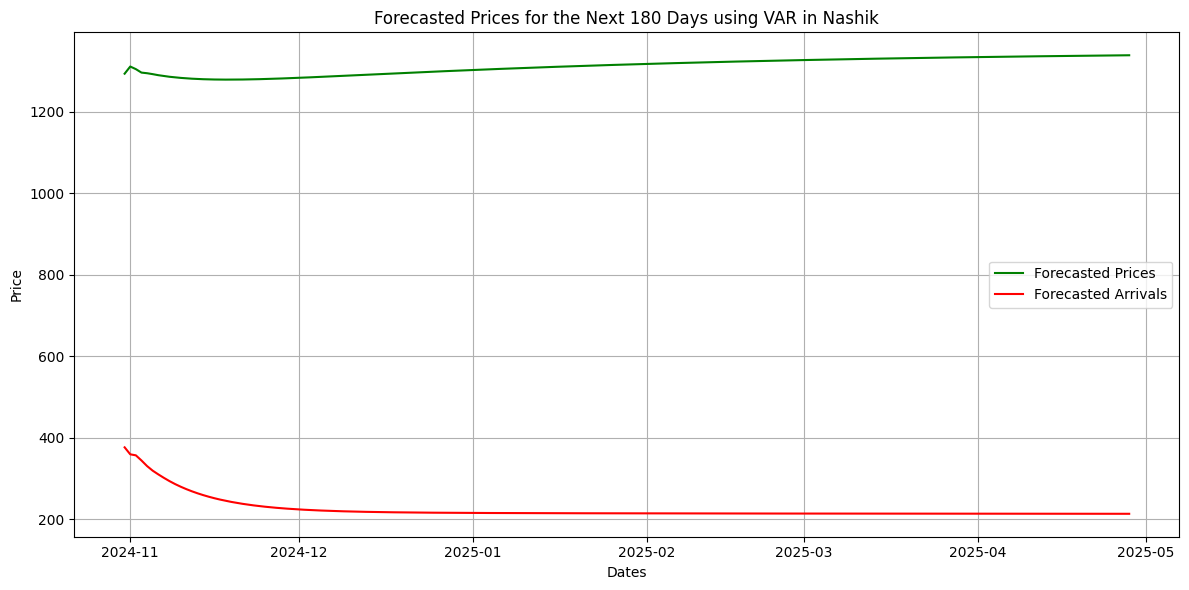

In [3]:
# Plotting the forecasted prices with dates only
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Price'], label='Forecasted Prices', color='green')
plt.plot(forecast_df.index, forecast_df['Arrival'], label='Forecasted Arrivals', color='red')
# Add labels and title
plt.title('Forecasted Prices for the Next 180 Days using VAR in Nashik')
plt.xlabel('Dates')
plt.ylabel('Price')

# Display the legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('var_with_price and arrival_forecast.png')
plt.show()

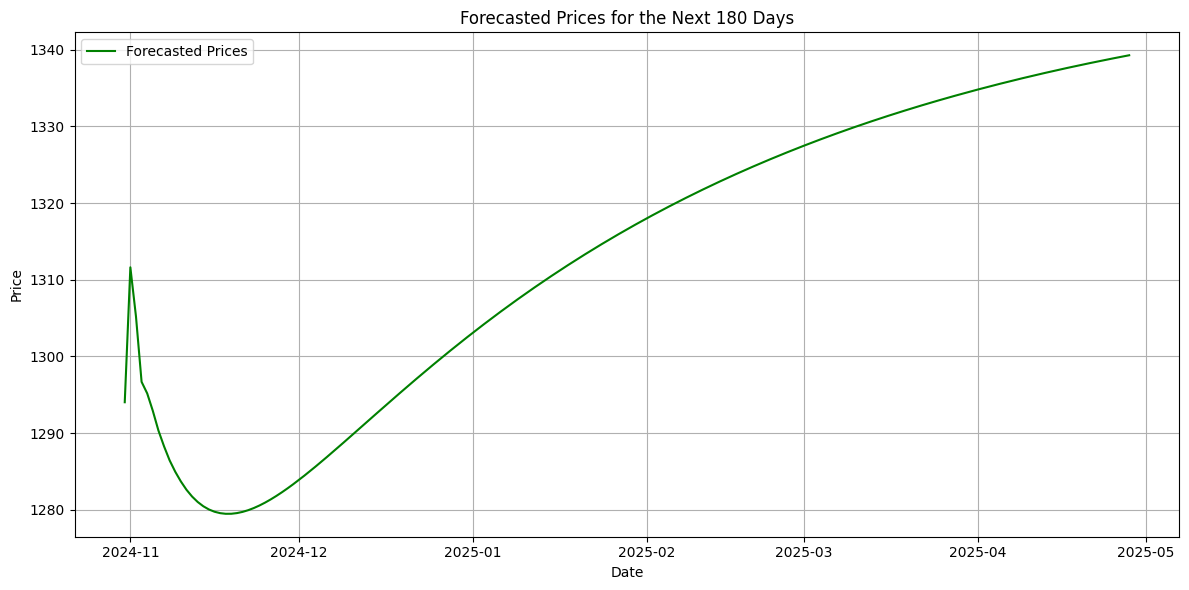

In [ ]:
# Plotting the forecasted prices with dates only
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Price'], label='Forecasted Prices', color='green')

# Add labels and title
plt.title('Forecasted Prices for the Next 180 Days')
plt.xlabel('Date')
plt.ylabel('Price')

# Display the legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


**ARIMAX**

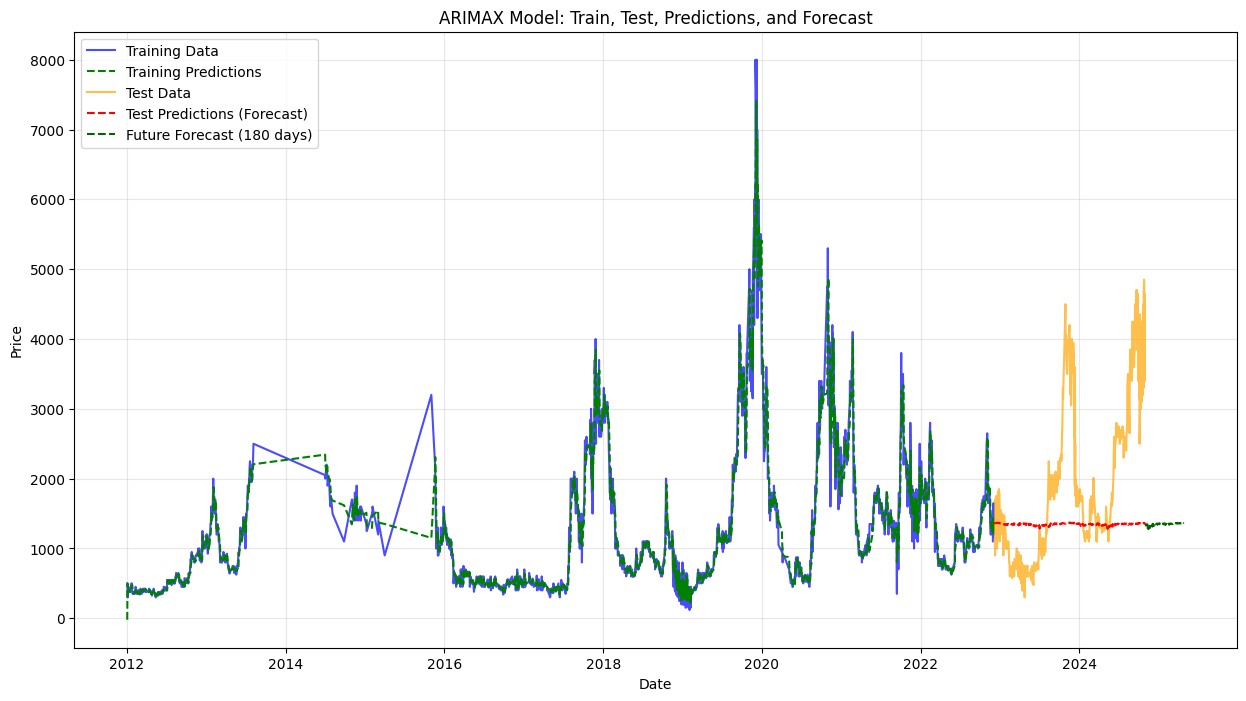

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
df = pd.read_csv("/content/Nashik_Onion_Updated_file_final12-24 (1).csv")  # Replace with your CSV file path
df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
df.set_index('Dates', inplace=True)

# Check for missing values in both 'Price' and 'Arrival'
df = df[['Price', 'Arrival']].dropna()

# Split data into train and test
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Define endogenous (Price) and exogenous (Arrival) variables
endog_train = train['Price']
endog_test = test['Price']
exog_train = train[['Arrival']]
exog_test = test[['Arrival']]

# Step 2: Fit ARIMAX Model (No seasonality)
arimax_model = SARIMAX(endog_train, exog=exog_train, order=(1, 1, 1),  # p, d, q
                       seasonal_order=(0, 0, 0, 0),  # Seasonal part is disabled
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_fitted = arimax_model.fit(disp=False)

# Step 3: Forecast on Test Data and beyond
n_forecast = len(test)
forecasted_values = arimax_fitted.get_forecast(steps=n_forecast, exog=exog_test).predicted_mean

# Forecast beyond the test set (e.g., next 180 days)
forecast_horizon = 180
future_exog = exog_test[-forecast_horizon:]  # You need to define future arrival data for these 180 days
forecast_future = arimax_fitted.get_forecast(steps=forecast_horizon, exog=future_exog).predicted_mean

# Step 4: Generate Train Predictions
train_predictions = arimax_fitted.predict(start=0, end=len(endog_train) - 1, exog=exog_train)

# Step 5: Plot Train, Test, Predictions, and Forecast
plt.figure(figsize=(15, 8))

# Plot the training data
plt.plot(train.index, train['Price'], label="Training Data", color="blue", alpha=0.7)

# Plot the training predictions
plt.plot(train.index, train_predictions, label="Training Predictions", color="green", linestyle="--")

# Plot the test data
plt.plot(test.index, test['Price'], label="Test Data", color="orange", alpha=0.7)

# Plot the test predictions (forecasted values)
plt.plot(test.index, forecasted_values, label="Test Predictions (Forecast)", color="red", linestyle="--")

# Plot the future forecast (next 180 days)
forecast_index = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
plt.plot(forecast_index, forecast_future, label="Future Forecast (180 days)", color="darkgreen", linestyle="--")

# Add titles and labels
plt.title("ARIMAX Model: Train, Test, Predictions, and Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


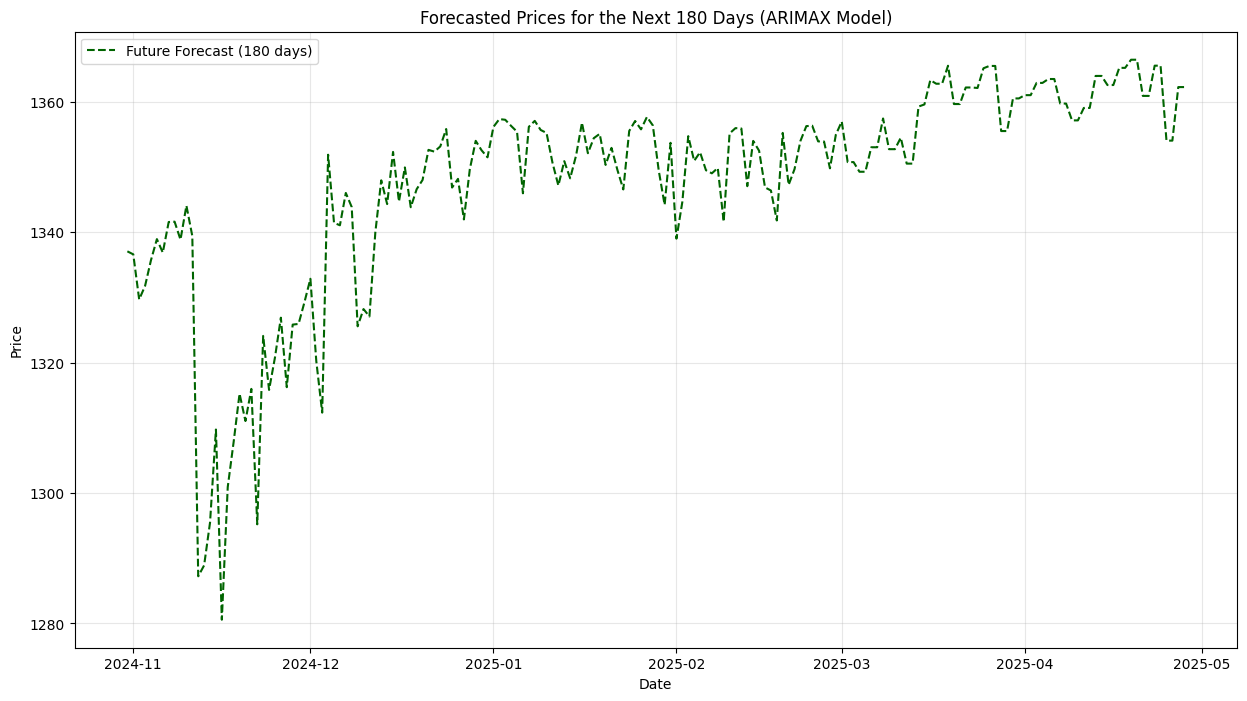

In [ ]:
# Plotting the forecasted prices with dates only
plt.figure(figsize=(15, 8))

# Plot the future forecast (next 180 days)
forecast_index = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
plt.plot(forecast_index, forecast_future, label="Future Forecast (180 days)", color="darkgreen", linestyle="--")

# Add titles and labels
plt.title("Forecasted Prices for the Next 180 Days (ARIMAX Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for Test Predictions
rmse = np.sqrt(mean_squared_error(endog_test, forecasted_values))

# Calculate NRMSE as a percentage (normalized by the range of actual values in test data)
nrmse = rmse / (endog_test.max() - endog_test.min()) * 100

# Print RMSE and NRMSE percentage
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}%")


RMSE: 1320.3214604175087
NRMSE: 29.01805407511008%


RANDOM **FOREST**

Testing lag: 1...
RMSE for lag 1: 1033.71
Testing lag: 2...
RMSE for lag 2: 728.76
Testing lag: 3...
RMSE for lag 3: 700.43
Testing lag: 4...
RMSE for lag 4: 672.21
Testing lag: 5...
RMSE for lag 5: 673.53
Testing lag: 6...
RMSE for lag 6: 686.27
Testing lag: 7...
RMSE for lag 7: 666.09
Testing lag: 8...
RMSE for lag 8: 659.02
Testing lag: 9...
RMSE for lag 9: 628.64
Testing lag: 10...
RMSE for lag 10: 681.75

Optimal lag found: 9 with RMSE: 628.64


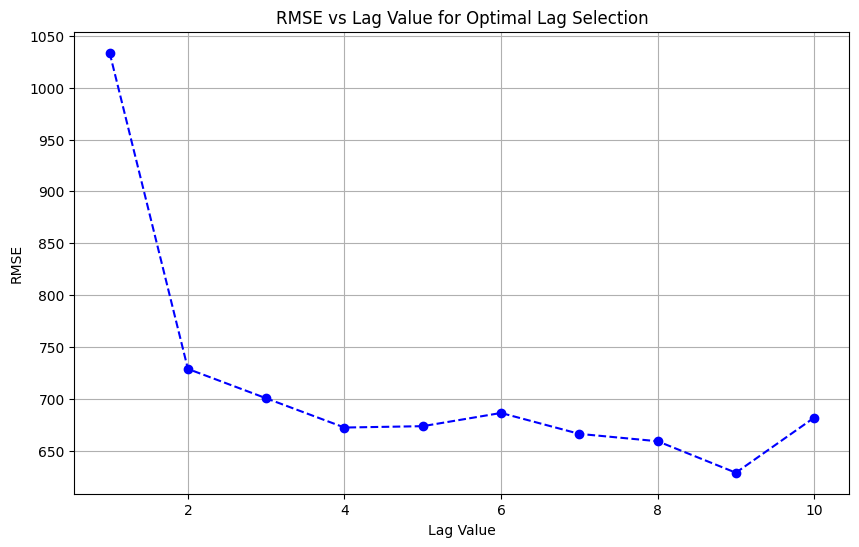

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Function to create lagged features for time series data
def create_lagged_features(data, lags=5):
    """
    Create lagged features for time series data.
    """
    df_lagged = data.copy()
    for lag in range(1, lags + 1):
        df_lagged[f"lag_{lag}"] = df_lagged['Price'].shift(lag)
    return df_lagged

def find_optimal_lag(data, max_lag=10):
    """
    Function to find the optimal lag by testing different lag values.
    """
    optimal_lag = None
    lowest_rmse = float('inf')  # Initialize with a large value

    # Store lag values and corresponding RMSEs for comparison
    rmse_values = []

    # Iterate over different lag values
    for lag in range(1, max_lag + 1):
        print(f"Testing lag: {lag}...")

        # Generate lagged features for the current lag value
        data_with_lags = create_lagged_features(data, lags=lag)
        data_with_lags.dropna(inplace=True)  # Remove rows with NaN values due to lagging

        # Split Data into Train and Test
        train = data_with_lags.iloc[:-10]
        test = data_with_lags.iloc[-10:]

        X_train = train.drop(columns=['Price'])
        y_train = train['Price']
        X_test = test.drop(columns=['Price'])
        y_test = test['Price']

        # Train Random Forest Regressor
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Make Predictions on Test Data
        rf_predictions = rf_model.predict(X_test)

        # Evaluate RMSE for this lag value
        rmse = mean_squared_error(y_test, rf_predictions, squared=False)
        rmse_values.append((lag, rmse))
        print(f"RMSE for lag {lag}: {rmse:.2f}")

        # Update the optimal lag if this one performs better
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            optimal_lag = lag

    # Display the lag with the lowest RMSE
    print(f"\nOptimal lag found: {optimal_lag} with RMSE: {lowest_rmse:.2f}")

    # Return the best lag and corresponding RMSE values for all lags
    return optimal_lag, rmse_values

# Load the CSV file with your data
lpath = "/content/Nashik_Onion_Updated_file_final12-24 (1).csv"  # Update with the correct path to your CSV file
df = pd.read_csv(lpath)

# Ensure 'Dates' is a datetime object
df['Dates'] = pd.to_datetime(df['Dates'])

# Set 'Dates' as the index for time series analysis
df.set_index('Dates', inplace=True)

# Check if required columns exist
if not {'Price', 'Arrival'}.issubset(df.columns):
    raise ValueError("The CSV file must contain 'Price' and 'Arrival' columns.")

# Find the optimal lag (you can adjust max_lag as needed)
optimal_lag, rmse_values = find_optimal_lag(df, max_lag=10)

# Plot RMSE for different lags to visualize
lags, rmses = zip(*rmse_values)
plt.figure(figsize=(10, 6))
plt.plot(lags, rmses, marker='o', color='b', linestyle='--')
plt.xlabel("Lag Value")
plt.ylabel("RMSE")
plt.title("RMSE vs Lag Value for Optimal Lag Selection")
plt.grid(True)
plt.show()



Loaded DataFrame:
            Arrival  Price
Dates                     
2012-01-02    194.0    500
2012-01-03    174.0    475
2012-01-04      7.0    300
2012-01-05    264.0    400
2012-01-06    192.5    400
Overall RMSE: 109.88711213948034
Overall NRMSE: 7.698148520122193%


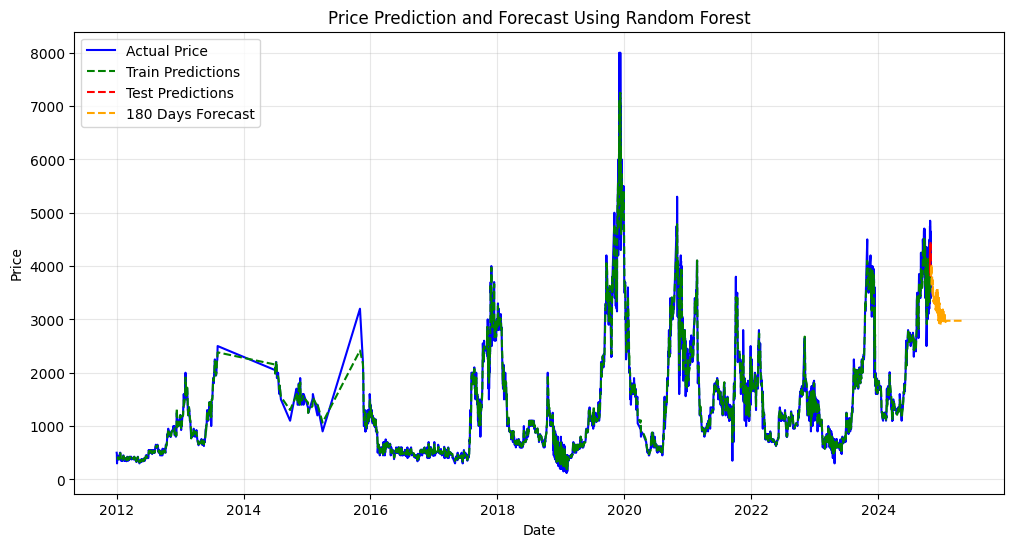

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the CSV File
lpath = "/content/Nashik_Onion_Updated_file_final12-24 (1).csv"  # Update with the correct path to your CSV file
df = pd.read_csv(lpath)

# Ensure 'Dates' is a datetime object
df['Dates'] = pd.to_datetime(df['Dates'])

# Set 'Dates' as the index for time series analysis
df.set_index('Dates', inplace=True)

# Check if required columns exist
if not {'Price', 'Arrival'}.issubset(df.columns):
    raise ValueError("The CSV file must contain 'Price' and 'Arrival' columns.")

# Plotting to confirm data
print("Loaded DataFrame:")
print(df.head())

# Create Lagged Features for Random Forest
def create_lagged_features(data, lags=5):
    """
    Create lagged features for time series data.
    """
    df_lagged = data.copy()
    for lag in range(1, lags + 1):
        df_lagged[f"lag_{lag}"] = df_lagged['Price'].shift(lag)
    return df_lagged

# Set lag to the optimum lag (9)
lags = 5

# Generate Lagged Features
data_with_lags = create_lagged_features(df, lags)
data_with_lags.dropna(inplace=True)  # Remove rows with NaN values due to lagging

# Split Data into Train and Test
train = data_with_lags.iloc[:-10]  # Use all data except the last 10 for training
test = data_with_lags.iloc[-10:]   # Use the last 10 data points for testing

X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions on Train Data and Test Data
train_predictions = rf_model.predict(X_train)
rf_predictions = rf_model.predict(X_test)

# Combine Train and Test Predictions for RMSE calculation
all_predictions = np.concatenate([train_predictions, rf_predictions])
all_actuals = np.concatenate([y_train.values, y_test.values])

# Calculate RMSE (Root Mean Squared Error) for the entire dataset
rmse = mean_squared_error(all_actuals, all_predictions, squared=False)

# Calculate NRMSE (Normalized RMSE) for the entire dataset
nrmse = rmse / all_actuals.mean()

# Print the RMSE and NRMSE percentages
print(f"Overall RMSE: {rmse}")
print(f"Overall NRMSE: {nrmse * 100}%")

# Add Predictions to Test Data for Plotting
test['RF_Predictions'] = rf_predictions
train['RF_Predictions'] = train_predictions

# Forecast Future Data (Next 180 Days)
forecast_steps = 180
last_known = X_test.iloc[-1].values  # Use the last known feature row from the test set
future_forecast = []

# Forecast the next 180 days (adjust the number of days as needed)
for i in range(forecast_steps):
    # Predict the next value
    prediction = rf_model.predict([last_known])[0]
    future_forecast.append(prediction)

    # Update lagged features for the next prediction
    last_known = np.roll(last_known, -1)  # Shift lagged features
    last_known[-1] = prediction  # Add the current prediction as the newest lag

# Convert Forecast to DataFrame
forecast_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(future_forecast, index=forecast_index, columns=['Forecasted Price'])

# Plot the results (Train, Test Predictions, and Forecast)
plt.figure(figsize=(12, 6))

# Plot Actual Price (Training and Test Data)
plt.plot(df['Price'], label="Actual Price", color='blue')

# Plot Train Predictions
plt.plot(train.index, train['RF_Predictions'], label="Train Predictions", color='green', linestyle='--')

# Plot Test Predictions
plt.plot(test.index, test['RF_Predictions'], label="Test Predictions", color='red', linestyle='--')

# Plot Forecast Predictions
plt.plot(forecast_df.index, forecast_df['Forecasted Price'], label="180 Days Forecast", color='orange', linestyle='--')

# Add titles and labels
plt.title("Price Prediction and Forecast Using Random Forest")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Save the results to an Excel file
output_path = "/content/randomforest_forecasted_prices_with_rmse.xlsx"
output_df = pd.concat([df['Price'], train['RF_Predictions'], test['RF_Predictions'], forecast_df['Forecasted Price']], axis=1)
output_df.columns = ['Actual Price', 'Train Predictions', 'Test Predictions', 'Forecasted Price']
output_df.to_excel(output_path, index=True)
print(f"Results saved to {output_path}")




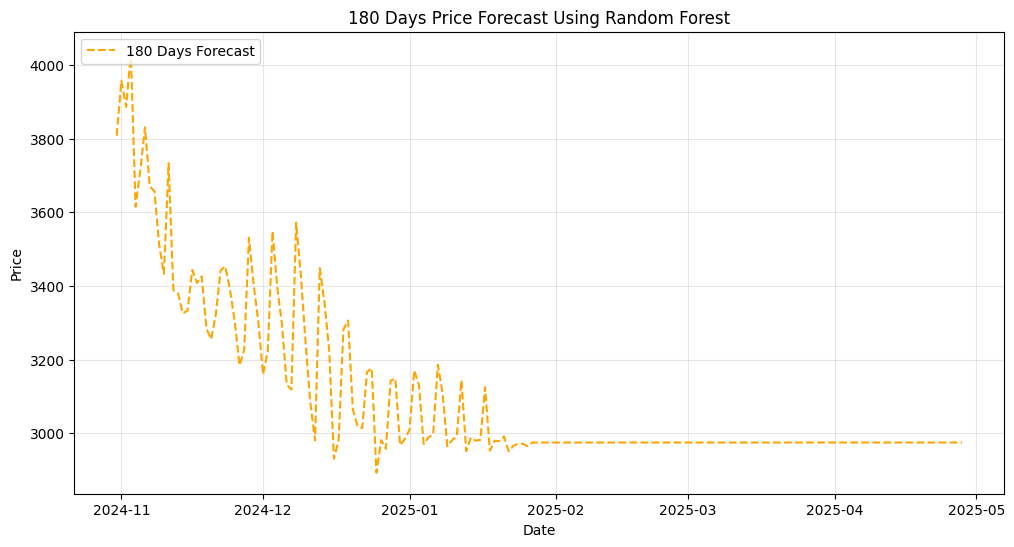

In [ ]:
# Plotting the forecasted prices with dates only
plt.figure(figsize=(12, 6))

# Plot Forecast Predictions (Next 180 Days)
plt.plot(forecast_df.index, forecast_df['Forecasted Price'], label="180 Days Forecast", color='orange', linestyle='--')

# Add titles and labels
plt.title("180 Days Price Forecast Using Random Forest")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


**LSTM**

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0139 - val_loss: 0.0024
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

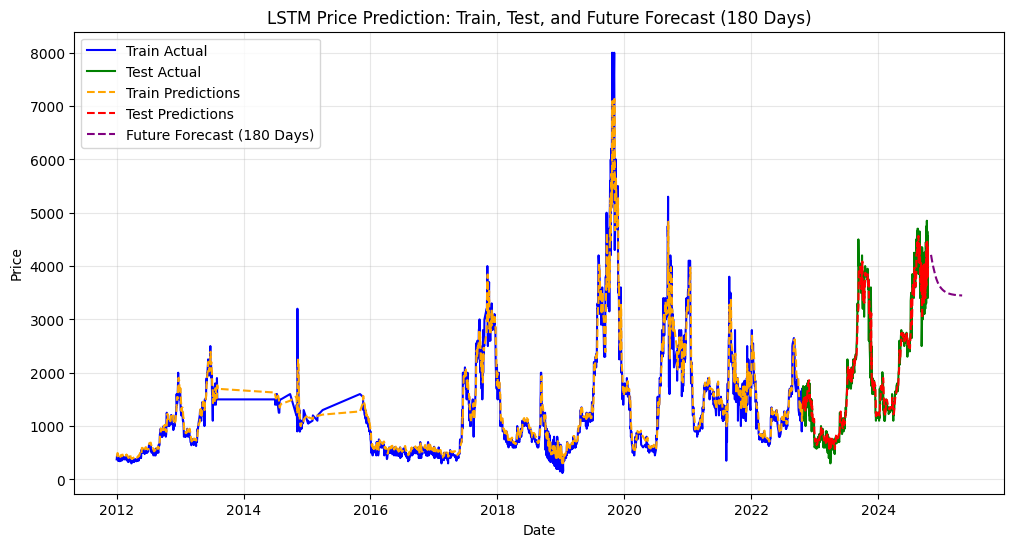

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Load Data from CSV
csv_file = "/content/Nashik_Onion_Updated_file_final12-24 (1).csv"  # Replace with your CSV file path
df = pd.read_csv(csv_file)

# Ensure data is sorted by time (assuming a 'Date' column exists)
df['Dates'] = pd.to_datetime(df['Dates'])  # Adjust if your column name is different
df = df.sort_values('Dates').set_index('Dates')

# Select target column
price_col = 'Price'  # Replace with your actual column name
arrival_col = 'Arrival'  # Replace with your actual column name

# Step 2: Data Preprocessing
# Normalize the target column (Price)
scaler = MinMaxScaler(feature_range=(0, 1))
df[price_col] = scaler.fit_transform(df[[price_col]])

# Create sequences of previous time steps as features (X) and the next time step as the target (y)
def create_sequences(data, time_steps):
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # previous time_steps
        y.append(data[i, 0])  # current time step
    return np.array(X), np.array(y)

# Create sequences for training
time_steps = 30  # Use 30 previous days to predict the next day
data = df[price_col].values
data = data.reshape(-1, 1)

X, y = create_sequences(data, time_steps)

# Reshape X to be 3D for LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 3: Split Data into Train and Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Step 5: Train the LSTM Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the Model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

# Step 7: Forecast Future Prices for 180 days
n_future = 180  # Forecast for the next 180 days

# Use the last 100 days for future predictions
last_sequence = data[-100:].reshape(1, 100, 1)

# Predict future prices for the next 180 days
future_predictions = []
for _ in range(n_future):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])

    # Update the input sequence for the next prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Step 8: Visualize the Train, Test Predictions, and Future Forecast for 180 Days in One Plot
plt.figure(figsize=(12, 6))

# Plot Train Data
plt.plot(df.index[:len(y_train)], y_train, label="Train Actual", color='blue')

# Plot Test Data
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], y_test, label="Test Actual", color='green')

# Plot Train Predictions
plt.plot(df.index[:len(y_train)], train_predictions, label="Train Predictions", color='orange', linestyle='--')

# Plot Test Predictions
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], test_predictions, label="Test Predictions", color='red', linestyle='--')

# Plot Future Forecast (180 Days)
forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_future)
plt.plot(forecast_dates, future_predictions, label="Future Forecast (180 Days)", color='purple', linestyle='--')

# Add titles and labels
plt.title("LSTM Price Prediction: Train, Test, and Future Forecast (180 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Save the forecast to CSV
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Price': future_predictions.flatten()
})
forecast_df.to_csv("lstm_price_forecast_180_days.csv", index=False)


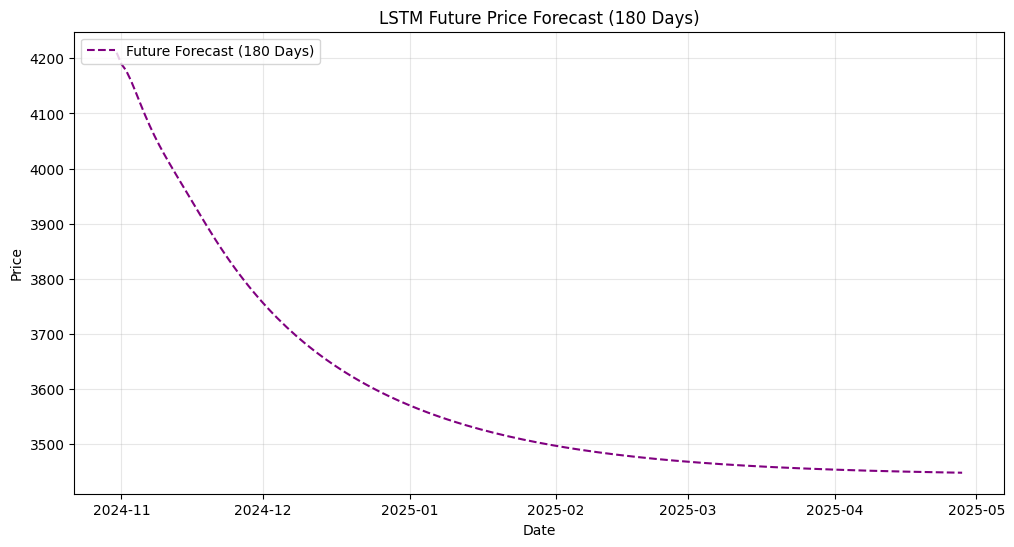

In [ ]:
# Plot the Future Forecast for 180 Days
plt.figure(figsize=(12, 6))

# Plot Future Forecast (180 Days)
forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_future)
plt.plot(forecast_dates, future_predictions, label="Future Forecast (180 Days)", color='purple', linestyle='--')

# Add titles and labels
plt.title("LSTM Future Price Forecast (180 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [ ]:
# Combine actual values from both training and testing sets
actual_values = np.concatenate((y_train, y_test), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)

# Calculate RMSE for the entire dataset
overall_rmse = np.sqrt(mean_squared_error(actual_values, predictions))

# Calculate NRMSE (Normalized RMSE) by dividing RMSE by the range of the actual values
overall_nrmse = overall_rmse / (np.max(actual_values) - np.min(actual_values))

# Convert NRMSE to percentage
overall_nrmse_percentage = overall_nrmse * 100

# Print overall RMSE and NRMSE percentage
print(f"Overall RMSE: {overall_rmse}")
print(f"Overall NRMSE: {overall_nrmse_percentage}%")



Overall RMSE: 266.2679979476546
Overall NRMSE: 3.3811809263194235%


**ANN WITH ARIMA**

RMSE: 631.5706731369437
NRMSE (%): 8.02


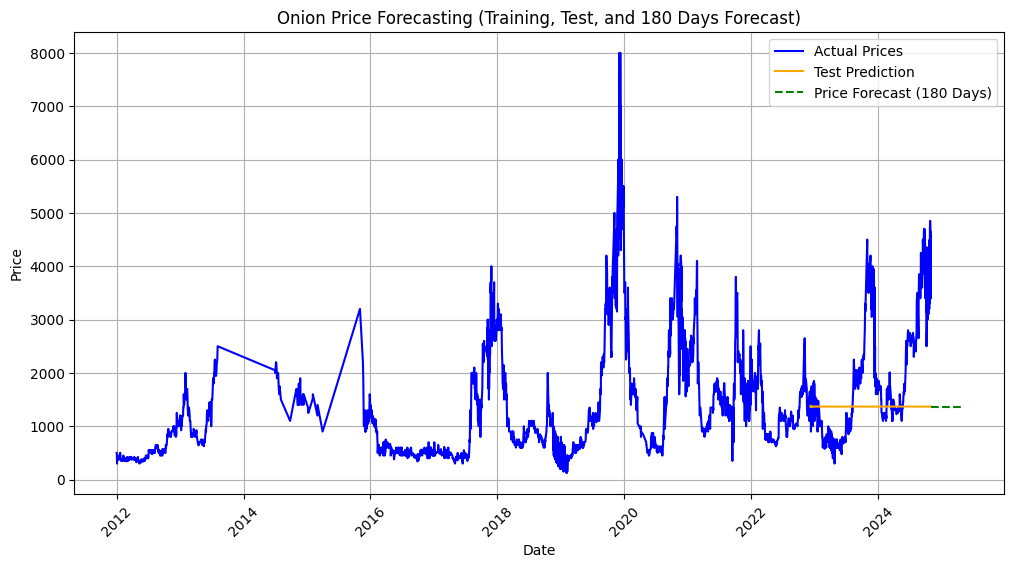

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

# Step 1: Load Data
df = pd.read_csv('/content/Nashik_Onion_Updated_file_final12-24 (1).csv')
df['Dates'] = pd.to_datetime(df['Dates'])  # Convert 'Date' to datetime
df.set_index('Dates', inplace=True)

# Step 2: Prepare the dataset
prices = df['Price']
prices = prices.values  # Convert to numpy array for modeling

# Split data into training and testing
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

# Step 3: Basic Model (ARIMA)
# Fit ARIMA model on the training data
arima_model = ARIMA(train, order=(3, 1, 0))  # Example order; tune for your data
arima_model_fit = arima_model.fit()

# Predict using ARIMA model
train_forecast = arima_model_fit.predict(start=0, end=train_size-1, typ='levels')
test_forecast = arima_model_fit.predict(start=train_size, end=len(prices)-1, typ='levels')

# Step 4: Error Classification
# Define the desired level of error (DLE)
DLE = 0.05  # 5% error threshold

# Classify errors into categories
def classify_errors(errors, DLE):
    category_A = errors[errors > DLE]  # Over-estimated
    category_B = errors[errors < -DLE]  # Under-estimated
    category_C = errors[(errors >= -DLE) & (errors <= DLE)]  # Neutral
    return category_A, category_B, category_C

train_errors = train - train_forecast
test_errors = test - test_forecast
train_A, train_B, train_C = classify_errors(train_errors, DLE)
test_A, test_B, test_C = classify_errors(test_errors, DLE)

# Step 5: Input Lists for the Second Model (ANN)
def prepare_input_lists(category_A, category_B, category_C):
    A = np.array([x if x in category_A else 0 for x in category_A])
    B = np.array([x if x in category_B else 0 for x in category_B])
    C = np.array([x if x in category_C else 0 for x in category_C])
    return A, B, C

train_A, train_B, train_C = prepare_input_lists(train_A, train_B, train_C)
test_A, test_B, test_C = prepare_input_lists(test_A, test_B, test_C)

# Step 6: Train ANN Models for Adjusting Errors (for categories A and B)
def train_ann_model(X, y):
    ann_model = MLPRegressor(hidden_layer_sizes=(300,), max_iter=4000)
    ann_model.fit(X, y)
    return ann_model

# Train ANN on overestimation and underestimation errors
X_train = np.array([train_A[:-1], train_A[1:]]).T
y_train = train_A[1:]
ann_model_A = train_ann_model(X_train, y_train)

X_train_B = np.array([train_B[:-1], train_B[1:]]).T
y_train_B = train_B[1:]
ann_model_B = train_ann_model(X_train_B, y_train_B)

# Step 7: Hybrid Forecasting
def hybrid_forecast(train_forecast, ann_model_A, ann_model_B, DLE):
    # Prepare the input in a format that the ANN expects: 2 features (e.g., using sliding window)
    train_forecast_reshaped = np.array([train_forecast[:-1], train_forecast[1:]]).T  # Two features (previous and current value)

    # Predict using the ANN models for both over-estimates and under-estimates
    forecast_A = ann_model_A.predict(train_forecast_reshaped)
    forecast_B = ann_model_B.predict(train_forecast_reshaped)

    # Hybrid forecast calculation
    hybrid_forecast_A = train_forecast[1:] + forecast_A  # Use the current forecast values for hybrid
    hybrid_forecast_B = train_forecast[1:] + forecast_B

    return hybrid_forecast_A, hybrid_forecast_B

# Call the function with the reshaped data
hybrid_forecast_A, hybrid_forecast_B = hybrid_forecast(train_forecast, ann_model_A, ann_model_B, DLE)

# Forecasting for 180 days ahead
forecast_days = 180
future_forecast = arima_model_fit.predict(start=len(prices), end=len(prices) + forecast_days - 1, typ='levels')

# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Combine actual, test, and forecast data for plotting
actual_dates = df.index
test_dates = df.index[train_size:]
combined_prices = np.concatenate([train, test, future_forecast])

# Step 8: Calculate Overall RMSE and NRMSE%
# Step 8: Combined Predictions for Training, Test, and Future Forecast

# Combine actual values (train + test) and predictions (train + test forecast)
actual_values = np.concatenate([train, test])
predicted_values = np.concatenate([train_forecast, test_forecast])

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate NRMSE (Normalized RMSE)
nrmse = (rmse / (np.max(actual_values) - np.min(actual_values))) * 100

# Print RMSE and NRMSE
print(f"RMSE: {rmse}")
print(f"NRMSE (%): {nrmse:.2f}")

# Step 9: Plotting the Graph for Actual and Predicted Prices

# Future Forecast for the next 180 days
future_forecast = arima_model_fit.predict(start=len(prices), end=len(prices) + 180 - 1, typ='levels')

# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 181)]

# Combine actual, test, and forecast data
forecast_dates_combined = np.concatenate([actual_dates, future_dates])
combined_prices = np.concatenate([prices, future_forecast])

# Plotting the combined graph
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, prices, label='Actual Prices', color='blue')
plt.plot(actual_dates[train_size:], test_forecast, label='Test Prediction', color='orange')
plt.plot(future_dates, future_forecast, label='Price Forecast (180 Days)', color='green', linestyle='--')
plt.legend()
plt.title('Onion Price Forecasting (Training, Test, and 180 Days Forecast)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


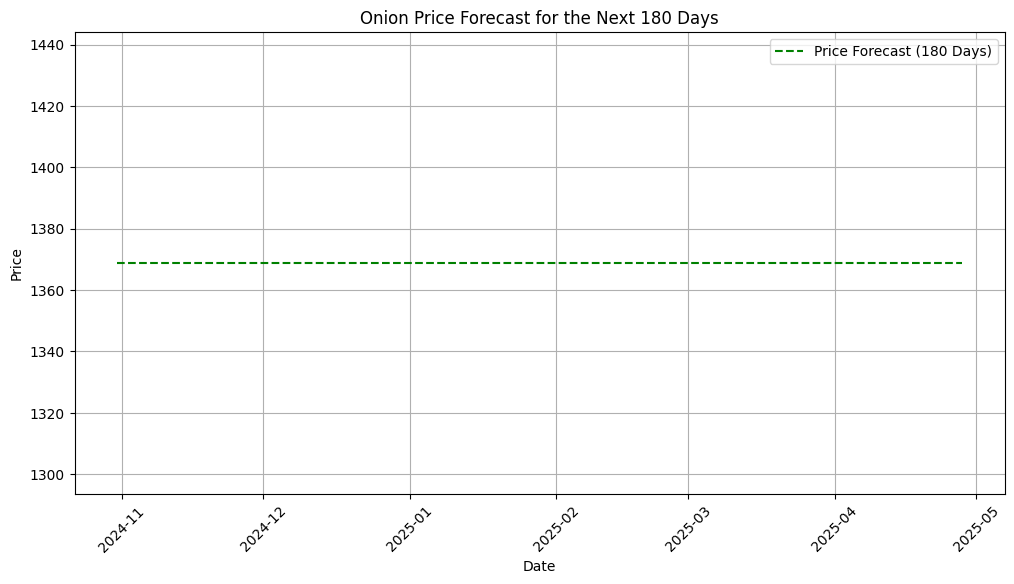

In [ ]:
# Future Forecast for the next 180 days
future_forecast = arima_model_fit.predict(start=len(prices), end=len(prices) + 180 - 1, typ='levels')

# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 181)]

# Plotting the Forecasted Prices vs. Dates (Future 180 Days)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_forecast, label='Price Forecast (180 Days)', color='green', linestyle='--')
plt.legend()
plt.title('Onion Price Forecast for the Next 180 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
